In [3]:
# import the necessary libraries
import numpy as np
from numpy import cross
from IPython.display import IFrame
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.2, rc={"lines.linewidth": 2})
import sys
sys.path.insert(1, r'./../functions')

In [4]:
# %load ./../functions/invdyn2d.py
"""Two-dimensional inverse-dynamics calculations of one segment."""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'invdyn2d.py v.2 2015/11/13'


def invdyn2d(rcm, rd, rp, acm, alpha, mass, Icm, Fd, Md):
    """Two-dimensional inverse-dynamics calculations of one segment

    Parameters
    ----------
    rcm   : array_like [x,y]
            center of mass position (y is vertical)
    rd    : array_like [x,y]
            distal joint position
    rp    : array_like [x,y]
            proximal joint position
    acm   : array_like [x,y]
            center of mass acceleration
    alpha : array_like [x,y]
            segment angular acceleration
    mass  : number
            mass of the segment   
    Icm   : number
            rotational inertia around the center of mass of the segment
    Fd    : array_like [x,y]
            force on the distal joint of the segment
    Md    : array_like [x,y]
            moment of force on the distal joint of the segment
    
    Returns
    -------
    Fp    : array_like [x,y]
            force on the proximal joint of the segment (y is vertical)
    Mp    : array_like [x,y]
            moment of force on the proximal joint of the segment

    Notes
    -----
    To use this function recursevely, the outputs [Fp, Mp] must be inputed as 
    [-Fp, -Mp] on the next call to represent [Fd, Md] on the distal joint of the
    next segment (action-reaction).
    
    This code was inspired by a similar code written by Ton van den Bogert [1]_.
    See this notebook [2]_.

    References
    ----------
    .. [1] http://isbweb.org/data/invdyn/index.html
    .. [2] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/GaitAnalysis2D.ipynb

    """
        
    g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
    # Force and moment of force on the proximal joint
    Fp = mass*acm - Fd - [0, -g*mass]
    Mp = Icm*alpha - Md - cross(rd-rcm, Fd) - cross(rp-rcm, Fp)
    
    return Fp, Mp

In [5]:
# load file with ground reaction force data
text_file="C:\\Users\\ferna\\Documents\\20222\\MSMH\\data\\all.frc"
grf = np.loadtxt(fname=text_file) # [Fx, Fy, COPx]
# load file with kinematic data
text_filou="C:\\Users\\ferna\\Documents\\20222\\MSMH\\data\\all.kin"
kin = np.loadtxt(fname=text_filou) # [Hip(x,y), knee(x,y), ankle(x,y), toe(x,y)] 
freq = 10000
time = np.linspace(0, grf.shape[0]/freq, grf.shape[0])
#"C:\Users\ferna\Documents\20222\MSMH\data\all.frc"


In [6]:
# heel strike occurs at sample 3001
time = time[3001 - int(freq/40):-int(freq/20)]
grf  = grf[3001 - int(freq/40):-int(freq/20), :]
kin  = kin[3001 - int(freq/40):-int(freq/20), :]

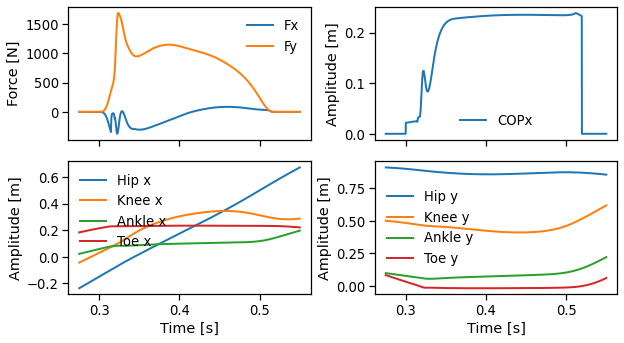

In [7]:
# plot data
hfig, hax = plt.subplots(2, 2, sharex = True, squeeze=True, figsize=(9, 5))
hax[0, 0].plot(time, grf[:, [0, 1]], linewidth=2)
hax[0, 0].legend(('Fx','Fy'), frameon=False)
hax[0, 0].set_ylabel('Force [N]')
hax[0, 1].plot(time, grf[:, 2], linewidth=2)
hax[0, 1].legend(['COPx'], frameon=False)
hax[0, 1].set_ylabel('Amplitude [m]')
hax[1, 0].plot(time, kin[:, 0::2], linewidth=2)
hax[1, 0].legend(('Hip x','Knee x','Ankle x','Toe x'), frameon=False)
hax[1, 0].set_ylabel('Amplitude [m]')
hax[1, 1].plot(time, kin[:, 1::2], linewidth=2)
hax[1, 1].legend(('Hip y','Knee y','Ankle y','Toe y'), frameon=False)
hax[1, 1].set_ylabel('Amplitude [m]')
hax[1, 0].set_xlabel('Time [s]'), hax[1, 1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [8]:
# body-segment parameters [thigh, shank, foot]
mass = [6.85, 2.86, 1.00]                 # mass [kg]
Icm  = [0.145361267, 0.042996389, 0.0200] # rotational inertia [kgm2]
cmpr = [0.4323725, 0.4334975, 0.0]        # CM [m] wrt. prox. joint [frac. segment len]


In [9]:
# Kinematic data
# center of mass position of the thigh, shank, foot segments
rcm = np.hstack((kin[:, [0,1]] + cmpr[0]*(kin[:, [2,3]] - kin[:, [0,1]]),
                 kin[:, [2,3]] + cmpr[1]*(kin[:, [4,5]] - kin[:, [2,3]]),
                 kin[:, [4,5]] + cmpr[2]*(kin[:, [6,7]] - kin[:, [4,5]])))

# center of mass linear acceleration of the thigh, shank, foot segments
acm = np.diff(rcm, n=2, axis=0)*freq*freq
acm = np.vstack((acm, acm[-1, :], acm[-1, :]))

# thigh, shank, foot segment angle
ang = np.vstack((np.arctan2(kin[:, 1] - kin[:, 3], kin[:, 0] - kin[:, 2]),
                 np.arctan2(kin[:, 3] - kin[:, 5], kin[:, 2] - kin[:, 4]),
                 np.arctan2(kin[:, 5] - kin[:, 7], kin[:, 4] - kin[:, 6]))).T


# hip, knee, and ankle joint angles
angj = np.vstack((-(ang[:, 0]-ang[:, 1]),
                  np.unwrap(ang[:, 1] - ang[:, 2] + np.pi/2))).T*180/np.pi

# thigh, shank, foot segment angular acceleration
aang = np.diff(ang, n=2, axis=0)*freq*freq
aang = np.vstack((aang, aang[-1, :], aang[-1, :]))

In [22]:
# %load ./../functions/invdyn2d.py
"""Two-dimensional inverse-dynamics calculations of one segment."""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'invdyn2d.py v.2 2015/11/13'


def invdyn2d(rcm, rd, rp, acm, alpha, mass, Icm, Fd, Md):
    
        
    g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
    # Force and moment of force on the proximal joint
    Fp = mass*acm - Fd - [0, -g*mass]
    Mp = Icm*alpha - Md - cross(rd-rcm, Fd) - cross(rp-rcm, Fp)
    
    return Fp, Mp
#Fp, Mp = invdyn2d(rcm, rd, rp, acm, alfa, mass, Icm, Fd, Md)

In [19]:
# %load ./../functions/invdyn2d.py
"""Two-dimensional inverse-dynamics calculations of one segment."""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'invdyn2d.py v.2 2015/11/13'


def invdyn2d(rcm, rd, rp, acm, alpha, mass, Icm, Fd, Md):
    
        
    g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
    # Force and moment of force on the proximal joint
    Fp = mass*acm - Fd - [0, -g*mass]
    Mp = Icm*alpha - Md - cross(rd-rcm, Fd) - cross(rp-rcm, Fp)
    
    return Fp, Mp
#Fp, Mp = invdyn2d(rcm, rd, rp, acm, alfa, mass, Icm, Fd, Md)

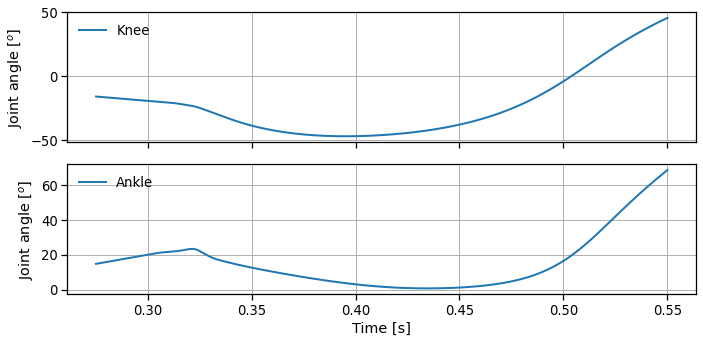

In [10]:
# plot hip, knee, and ankle joint angles
hfig, (hax1, hax2) = plt.subplots(2, 1, sharex = True, squeeze=True, figsize=(10, 5))
hax1.plot(time, angj[:, 0], linewidth=2, label='Knee')
hax1.legend(frameon=False, loc='upper left'), hax1.grid()
hax2.plot(time, angj[:, 1], linewidth=2, label='Ankle')
hax2.legend(frameon=False, loc='upper left'), hax2.grid()
hax1.set_ylabel('Joint angle $[^o]$')
hax2.set_ylabel('Joint angle $[^o]$')
hax2.set_xlabel('Time [s]')
plt.tight_layout()
plt.show()

In [19]:
# %load ./../functions/invdyn2d.py
"""Two-dimensional inverse-dynamics calculations of one segment."""

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = 'invdyn2d.py v.2 2015/11/13'


def invdyn2d(rcm, rd, rp, acm, alpha, mass, Icm, Fd, Md):
    
        
    g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)
    # Force and moment of force on the proximal joint
    Fp = mass*acm - Fd - [0, -g*mass]
    Mp = Icm*alpha - Md - cross(rd-rcm, Fd) - cross(rp-rcm, Fp)
    
    return Fp, Mp
#Fp, Mp = invdyn2d(rcm, rd, rp, acm, alfa, mass, Icm, Fd, Md)

In [20]:
# inverse dynamics
#from invdyn2d import invdyn2d

# ankle
Fa, Ma = invdyn2d(rcm[:,(4,5)], grf[:,(2,2)]*[1,0], kin[:,(4,5)],
                    acm[:,(4,5)], aang[:, 2], mass[2], Icm[2],
                    grf[:, (0, 1)], 0)
# knee
Fk, Mk = invdyn2d(rcm[:,(2,3)], kin[:,(4,5)], kin[:,(2,3)],
                    acm[:,(2,3)], aang[:,1], mass[1], Icm[1],
                    -Fa, -Ma)
# hip
Fh, Mh = invdyn2d(rcm[:,(0,1)], kin[:,(2,3)], kin[:,(0,1)],
                    acm[:,(0,1)], aang[:,0], mass[0], Icm[0],
                    -Fk, -Mk)

# magnitude of the calculated hip, knee, and ankle resultant joint force
Fam = np.sqrt(np.sum(np.abs(Fa)**2, axis=-1))
Fkm = np.sqrt(np.sum(np.abs(Fk)**2, axis=-1))
Fhm = np.sqrt(np.sum(np.abs(Fh)**2, axis=-1))

In [24]:
# load file with true joint forces and moments of force
text_file3="C:\\Users\\ferna\\Documents\\20222\\MSMH\\data\\all.fmg"
forces  = np.loadtxt(fname=text_file3) # [Hip, knee, ankle]
text_file4 = "C:\\Users\\ferna\\Documents\\20222\\MSMH\\data\\all.mom"
moments = np.loadtxt(fname=text_file4) # [Hip, knee, ankle]
#heel strike occurs at sample 3001
forces  = forces[3001-int(freq/40):-int(freq/20), :]
moments = moments[3001-int(freq/40):-int(freq/20), :]

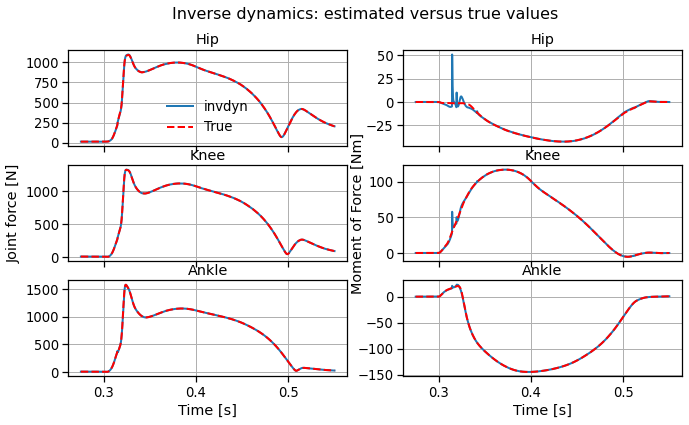

In [25]:
def plotdata(time, Fh, Fk, Fa, Mh, Mk, Ma, forces, moments, stitle):
    # plot hip, knee, and ankle moments of force
    hfig, hax = plt.subplots(3, 2, sharex = True, squeeze=True, figsize=(11, 6))
    # forces
    hax[0, 0].plot(time, Fh, label='invdyn'), hax[0, 0].set_title('Hip')
    hax[1, 0].plot(time, Fk), hax[1, 0].set_title('Knee')
    hax[2, 0].plot(time, Fa), hax[2, 0].set_title('Ankle')
    hax[1, 0].set_ylabel('Joint force [N]')
    hax[2, 0].set_xlabel('Time [s]')
    # moments of force
    hax[0, 1].plot(time, Mh), hax[0, 1].set_title('Hip')
    hax[1, 1].plot(time, Mk), hax[1, 1].set_title('Knee')
    hax[2, 1].plot(time, Ma), hax[2, 1].set_title('Ankle')
    hax[1, 1].set_ylabel('Moment of Force [Nm]')
    hax[2, 1].set_xlabel('Time [s]')
    # true joint forces and moments of force
    hax[0, 0].plot(time,  forces[:, 0], 'r--', label='True')
    hax[0, 0].legend(frameon=False) 
    hax[1, 0].plot(time,  forces[:, 1], 'r--') 
    hax[2, 0].plot(time,  forces[:, 2], 'r--')
    hax[0, 1].plot(time, moments[:, 0], 'r--') 
    hax[1, 1].plot(time, moments[:, 1], 'r--') 
    hax[2, 1].plot(time, moments[:, 2], 'r--')
    plt.suptitle(stitle, fontsize=16)
    for x in hax.flat:
        x.locator_params(nbins=5); x.grid()
    plt.show()
    
plotdata(time, Fhm, Fkm, Fam, Mh, Mk, Ma, forces, moments, 
         'Inverse dynamics: estimated versus true values')